In [43]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params
from hnn_core.network_models import add_erp_drives_to_jones_model
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import utils
device = 'cpu'

In [44]:
class model_ann(nn.Module):
    def __init__(self, input_size, output_size, layer_size):
        super(model_ann, self).__init__()
        self.input_size,  self.layer_size, self.output_size = input_size, layer_size, output_size

        #List layer sizes
        self.layer_hidden = np.concatenate([[input_size], layer_size, [output_size]])
        
        #Compile layers into lists
        self.layer_list = nn.ModuleList(
            [nn.Linear(in_features=self.layer_hidden[idx], out_features=self.layer_hidden[idx+1]) for idx in range(len(self.layer_hidden)-1)] )        
 
    def forward(self, x):
        #Encoding step
        for idx in range(len(self.layer_list)):
            x = torch.tanh(self.layer_list[idx](x))

        return x

In [45]:
#LSTM/GRU architecture for decoding
class model_lstm(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim=100, n_layers=2, dropout=0.1, device='cpu', bidirectional=False):
        super(model_lstm, self).__init__()

        #multiplier based on bidirectional parameter
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1

        # Defining some parameters
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers * num_directions
        self.device = device
        self.dropout = dropout
        self.bidirectional = bidirectional

        #Defining the layers
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True, dropout=dropout)   

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim*num_directions, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
    
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)
        
        out_tensor = torch.zeros(x.size(0), x.size(1), self.output_size)
        x_input = x[:, 0:1, :]  # weird indexing to maintain 3D shape for tensor
        for time_idx in range(seq_len):
            # Passing in the input and hidden state into the model and obtaining outputs
            out, hidden = self.lstm(x_input, hidden)
        
            # Reshaping the outputs such that it can be fit into the fully connected layer
            out = out.contiguous()
            out = self.fc(out)
            out_tensor[:, time_idx:(time_idx+1), :] = out
            
            x_input = x[:, (time_idx+1):(time_idx+2), :]
            x_input[:, :, :self.output_size] = out
            
        return out_tensor
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        weight = next(self.parameters()).data.to(self.device)

        # LSTM cell initialization
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device))
    

        return hidden


def add_noise(net):
    rate = 10
    weight = 0.01
    # Add Poisson drives
    weights_ampa_d1 = {'L2_pyramidal': weight, 'L5_pyramidal': weight,
                       'L2_basket': weight}
    rates_d1 = {'L2_pyramidal': rate, 'L5_pyramidal': rate, 'L2_basket': rate}

    net.add_poisson_drive(
        name='distal', tstart=0, tstop=None, rate_constant=rates_d1, location='distal', n_drive_cells='n_cells',
        cell_specific=True, weights_ampa=weights_ampa_d1, weights_nmda=None, space_constant=1e50,
        synaptic_delays=0.0, probability=1.0, event_seed=1, conn_seed=2)

    weights_ampa_p1 = {'L2_pyramidal': weight, 'L5_pyramidal': weight,
                       'L2_basket': weight, 'L5_basket': weight}
    rates_p1 = {'L2_pyramidal': rate, 'L5_pyramidal': rate, 'L2_basket': rate, 'L5_basket': rate}

    net.add_poisson_drive(
        name='proximal', tstart=0, tstop=None, rate_constant=rates_p1, location='proximal', n_drive_cells='n_cells',
        cell_specific=True, weights_ampa=weights_ampa_p1, weights_nmda=None, space_constant=1e50,
        synaptic_delays=0.0, probability=1.0, event_seed=3, conn_seed=4)

In [46]:
%%capture
hnn_core_root = op.dirname(hnn_core.__file__)
params_fname = op.join(hnn_core_root, 'param', 'default.json')
params = read_params(params_fname)
params.update({'N_pyr_x': 3, 'N_pyr_y': 3})
net = calcium_model(params)
add_noise(net)

dt = 0.5
dpl = simulate_dipole(net, dt=dt, tstop=5000, record_vsec='all', record_isec='all')

In [47]:
cell_type = 'L5_pyramidal'
cell_gids = net.gid_ranges[cell_type]


cell_voltage_list = list()
cell_current_list = list()
for gid in cell_gids:
    voltage_list = list()
    # Get voltages
    voltage_list = [vsec for vsec in  net.cell_response.vsec[0][gid].values()]
    cell_voltage_list.append(voltage_list)

    current_list = list()
    # Get currents
    for sec_name in net.cell_response.isec[0][gid].keys():
        current_list.extend([isec for isec in net.cell_response.isec[0][gid][sec_name].values()])

    cell_current_list.append(current_list)

# Recordings stored in shape (num_cells x num_rec_sites x time)
cell_voltages = np.stack(cell_voltage_list)
cell_currents = np.stack(cell_current_list)

n_voltages = cell_voltages.shape[1]  # first n_volumns used as prediction target

sim_data = np.concatenate([cell_voltages, cell_currents], axis=1)


In [48]:
class MultiComp_Dataset(torch.utils.data.Dataset):
    #'Characterizes a dataset for PyTorch'
    def __init__(self, sim_data, n_voltages, data_step_size=1, window_size=100, scaler=None, device='cpu'):
        
        self.n_cells, self.n_rec_sites, self.n_times = sim_data.shape
        self.sim_data = [sim_data[idx,:,:].T for idx in range(sim_data.shape[0])]
        
        self.n_voltages = n_voltages
        self.data_step_size = data_step_size
        self.window_size = window_size
        self.device = device
        
        if scaler is None:
            self.scaler = StandardScaler()
            self.scaler.fit(np.vstack(self.sim_data))

        self.sim_data_tensor = self.process_data(self.sim_data)
        
        # X is one step behind y
        self.X_tensor = self.sim_data_tensor[:, :-1, :]
        self.y_tensor = self.sim_data_tensor[:, 1:, :n_voltages]
        assert self.X_tensor.shape[0] == self.y_tensor.shape[0]
        self.num_samples = self.X_tensor.shape[0]

    
    def __len__(self):
        #'Denotes the total number of samples'
        return self.num_samples

    def __getitem__(self, slice_index):
        return self.X_tensor[slice_index,:,:], self.y_tensor[slice_index,:,:]
    
    def process_data(self, sim_data):
        unfolded_list = list()
        for idx in range(len(sim_data)):
            sim_data_transformed = self.scaler.transform(sim_data[idx])
            sim_data_transformed = torch.from_numpy(sim_data_transformed)
            sim_data_unfolded = sim_data_transformed.unfold(0, self.window_size + 1, self.data_step_size).transpose(1,2)
            
            unfolded_list.append(sim_data_unfolded)
        sim_data_tensor = torch.concat(unfolded_list)
        return sim_data_tensor
        
        

In [49]:
train_size = int(sim_data.shape[2] * 0.6)

In [50]:
training_set = MultiComp_Dataset(sim_data[:,:,:train_size], n_voltages)
validation_set = MultiComp_Dataset(sim_data[:,:,train_size:], n_voltages)

_, _, input_size = training_set[:][0].numpy().shape
_, _, output_size = training_set[:][1].numpy().shape

In [51]:
model = model_lstm(input_size=input_size, output_size=output_size)
# model = model_ann(input_size=input_size, output_size=output_size, layer_size=[10,10,10])

In [52]:
lr = 1e-2
weight_decay = 1e-5
max_epochs = 100
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [53]:
batch_size = 10000
num_cores = 1

train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}

training_generator = torch.utils.data.DataLoader(training_set, **train_params)
training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)
validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

validation_generator = torch.utils.data.DataLoader(validation_set, **test_params)

In [54]:
#Train model
loss_dict = utils.train_validate_model(model, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 5)


KeyboardInterrupt: 

In [33]:
# torch.save(model.state_dict(), 'L5_pyramidal_model.pt')

In [34]:
def simulate_model(model, validation_set, device='cpu'):
    with torch.no_grad():
        model.eval()
        
        # Prepare inputs with just synaptic currents
        validation_data = validation_set[:][0][:, -1:, :]
        input_data = np.zeros((validation_data.size()))
        
        # Only include true voltages at first time step
        input_data[:, 0:1, :] = validation_data[:, 0:1, :]
        # Fill rest of array with synaptic inputs (skip first n columns with voltage data)
        input_data[:, 0:1, validation_set.n_voltages:] = validation_data[:, 0:1, validation_set.n_voltages:]

        input_tensor = torch.tensor(input_data).float().to(device)

        out = model(input_tensor)
        
        
    out = out.detach().cpu().numpy()
    return out

In [41]:
test_pred = simulate_model(model, validation_set)
test_pred = test_pred.squeeze()

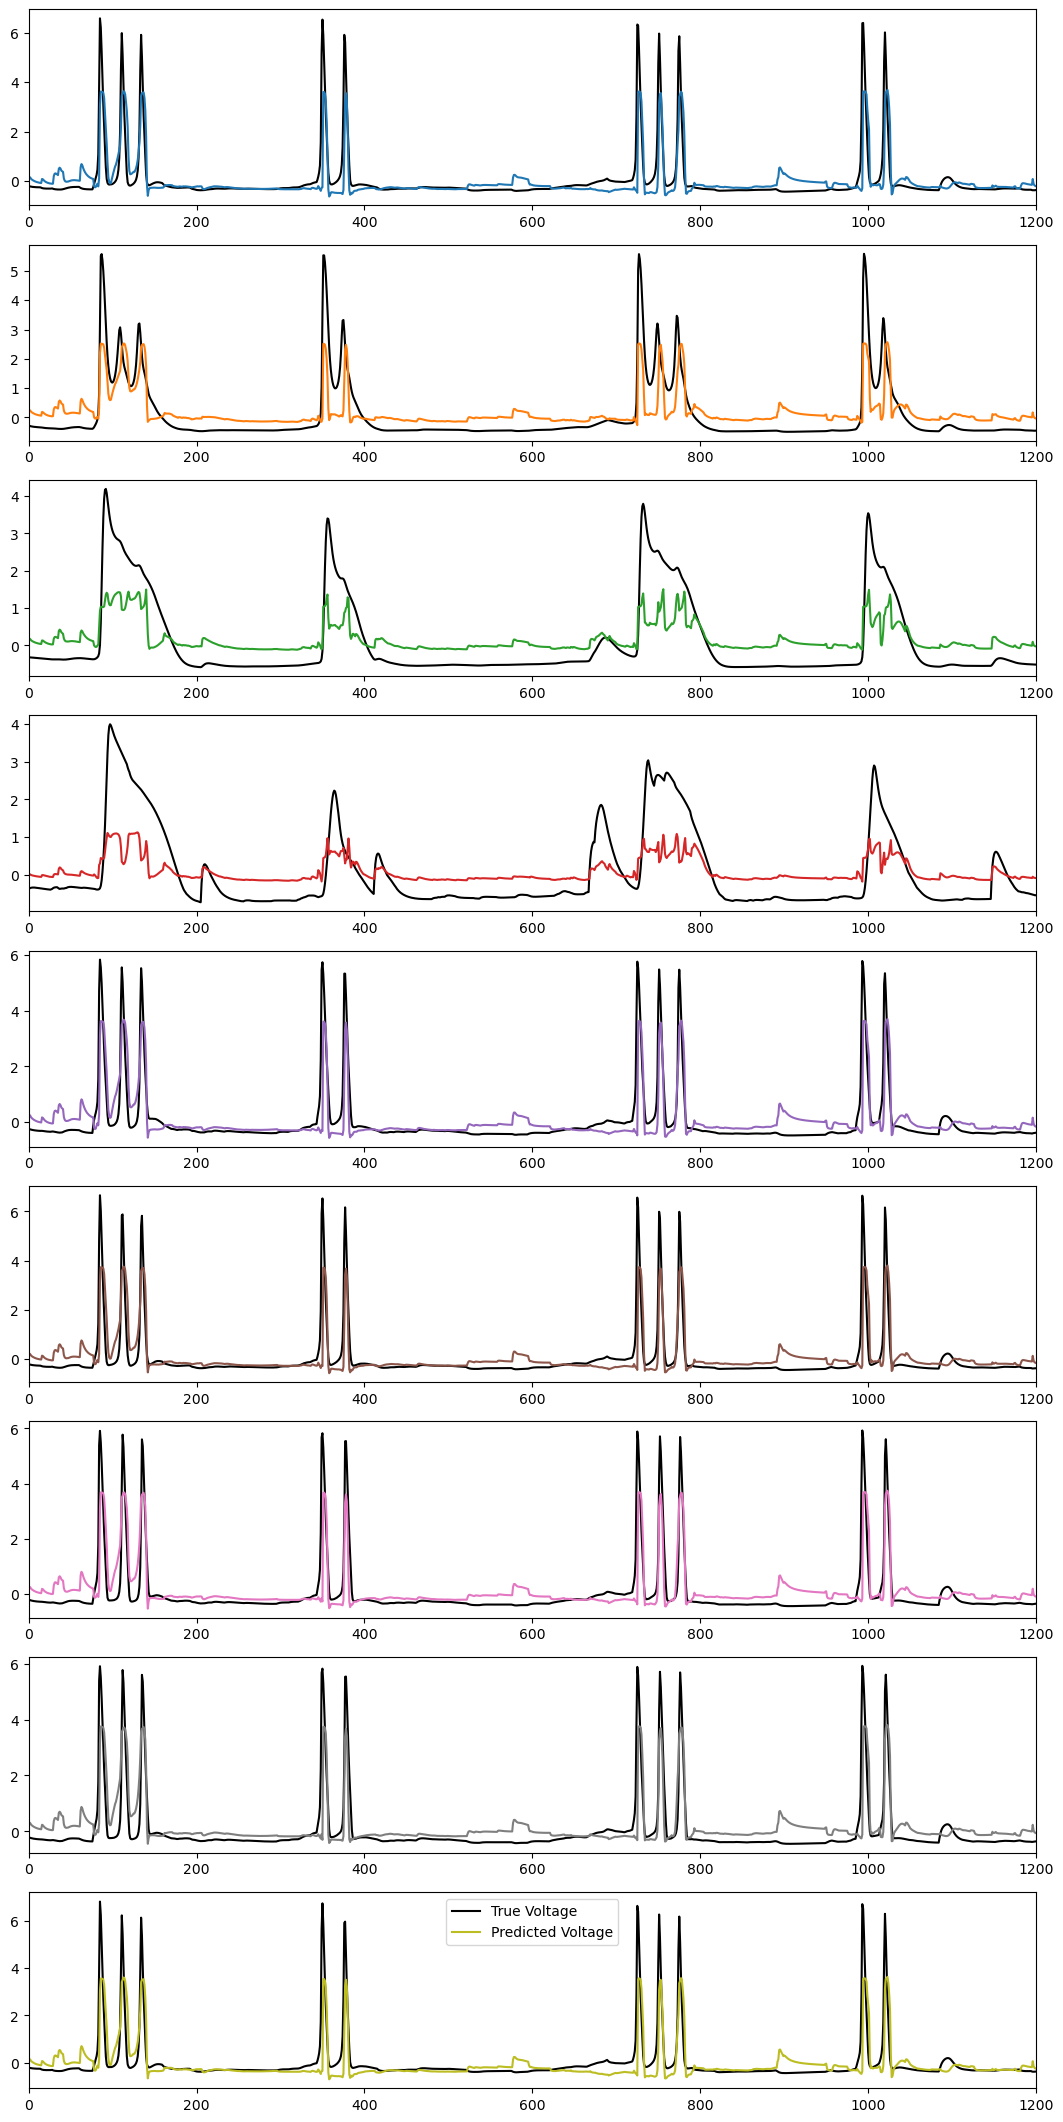

In [42]:

plt.figure(figsize=(13,3 * output_size))

for idx in range(output_size):
    plt.subplot(output_size, 1, idx+1)
    plt.plot(validation_set[:][1][:,-1,idx], color='k', label='True Voltage')
    plt.plot(test_pred[:,idx], color=f'C{idx}', label='Predicted Voltage')
    plt.xlim(0,1200)
plt.legend()


In [38]:
output_size

9

In [63]:
net.cell_response

<CellResponse | 1 simulation trials>

In [ ]:
#Evaluate trained model
ann_train_pred = mocap_functions.evaluate_model(model_ann, training_eval_generator, device)
ann_test_pred = mocap_functions.evaluate_model(model_ann, testing_generator, device)

#Compute decoding performance
ann_train_corr = mocap_functions.matrix_corr(ann_train_pred,y_train_data)
ann_test_corr = mocap_functions.matrix_corr(ann_test_pred,y_test_data)



In [46]:
# #Generate cv_dict for regular train/test/validate split (no rolling window)
# cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
# val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
# cv_dict = {}
# for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(np.arange(num_trials))):
#     for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
#         cv_dict[fold] = {'train_idx':train_val_idx[t_idx], 
#                          'test_idx':test_idx, 
#                          'validation_idx':train_val_idx[v_idx]} 